In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import wandb
from sklearn.metrics import accuracy_score,classification_report,f1_score, precision_score, recall_score

In [2]:
df = pd.read_csv('Data/WineQT.csv')
y = pd.get_dummies(df['quality'])
categories,counts = np.unique(df['quality'],return_counts = True)
y = np.where(y == True, 1.0,0.0)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,3
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1592
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1593
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1594
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1595


# 1.1 Dataset Analysis and Preprocessing
- We have splitted the data into 70% train, 15% validation and 15% test
- for normalising the data we have used standardscalar of the sklearn which transforms each attribute by so that the mean and variance for that feature in the data space are 0 and 1 respectively. This helps in convergence and bringing all features down to same scale so that they dont influence the gradient descent more than they should

In [15]:
stats= (df.describe()).loc[["mean","std","min","max"]]
stats

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


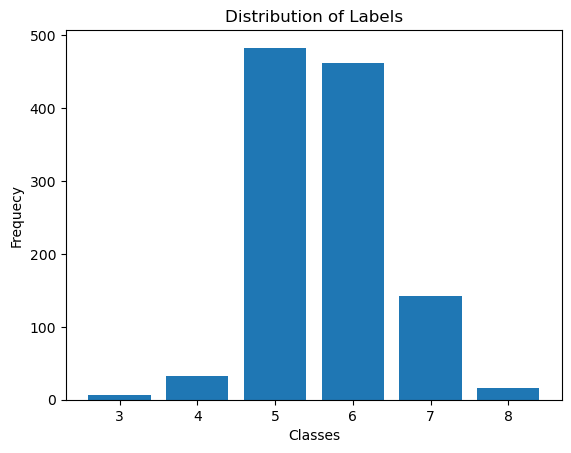

In [4]:
plt.bar(categories,counts)
plt.title('Distribution of Labels')
plt.xlabel('Classes')
plt.ylabel('Frequecy')
plt.show()

In [5]:
x_train, x_rest, y_train, y_rest = train_test_split(df.iloc[:,:-2], y, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_rest, y_rest, test_size=0.5, random_state=42)
scalar = StandardScaler()
scalar.fit(x_train.values)
x_train = scalar.transform(x_train.values)
x_val = scalar.transform(x_val.values)
x_test = scalar.transform(x_test.values)

In [6]:
# Replacing nan values after normalisation with 0
x_train[np.isnan(x_train)] = 0
x_val[np.isnan(x_val)] = 0
x_test[np.isnan(x_test)] = 0

# 1.2 Model Building from Scratch

## Model

In [7]:
def Xent(y_true,y_pred):
    eps = 1e-15
    return -np.sum(y_true*np.log(y_pred+eps)) / len(y_true)


class LogisticRegression:
    def __init__(self,input_size,output_size,lr):
        self.lr = lr
        self.input_size = input_size
        self.output_size = output_size
        self.weights_and_bias = np.random.randn(output_size,input_size+1)
        self.out = np.zeros(output_size)
        
    def Softmax(self,y):
        total = np.exp(y)
        return total / np.sum(total,axis =1,keepdims = True)
    
    def XentGrad(self,y_true,y_pred):
        eps = 1e-15
        return -(1/len(y_true))*(y_true*(1/(y_pred+eps)))
    
    def softmax_jacobian(self,p):
        n = p.shape[1]
        jacobian = np.zeros((len(p),n, n))
        
        for sample in range(len(p)):
            for i in range(n):
                for j in range(n):
                    if i == j:
                        jacobian[sample,i, j] = p[sample,i] * (1 - p[sample,i])
                    else:
                        jacobian[sample,i, j] = -p[sample,i] * p[sample,j]

        return jacobian
        
    def forward(self,x):
        x = np.append(x,np.ones((x.shape[0],1)),axis=1)
        self.input = x # (914.12)
        y = x @ self.weights_and_bias.T
        y_prob = self.Softmax(y) # (914,7)
        self.out = y_prob
        return y_prob
    
    def backward(self,y_true):
        grad_y_prob = self.XentGrad(y_true,self.out) # (914,7)
        grad_y = np.vectorize(lambda jac,grad: np.dot(jac,grad),signature='(n,n),(n)->(n)')(self.softmax_jacobian(self.out),grad_y_prob)  # (914,7)
        grad_w_and_b = grad_y.T @  self.input # (7,12)
        
        self.weights_and_bias -= self.lr*grad_w_and_b

In [8]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: khushi1703 (smai-khushi). Use `wandb login --relogin` to force relogin


True

## Model training, validation and W&B logging of results

In [11]:
wandb.init(project = "Multinomial Logistic Regression")
lrs = np.arange(0.01,0.55,0.05)
epochs = np.arange(500,3000,500)
for lr in lrs:
    for epoch in epochs:
        classifier = LogisticRegression(x_train.shape[1],y_train.shape[1],lr)
#       Training
        for epoch_ in range(epoch):
            out = classifier.forward(x_train)
            loss = Xent(y_train,out)
            classifier.backward(y_train)
#       Training metrics
        out = classifier.forward(x_train)
        predicted = np.argmax(out,axis = 1)
        actual = np.argmax(y_train,axis = 1)
        accuracy = accuracy_score(actual,predicted)
        loss = Xent(y_train,out)
        print("TRAINING")
        print(f"Epoch [{epoch}], lr [{lr}] Training => Accuracy : {accuracy:.4f}")
        print(f"Epoch [{epoch}], lr [{lr}] Training => Loss : {loss:.4f}")


#       Validation
        out = classifier.forward(x_val)
        predicted = np.argmax(out,axis = 1)
        actual = np.argmax(y_val,axis = 1)
        metrics = classification_report(actual,predicted,zero_division=0)
        accuracy = accuracy_score(actual,predicted)
        print("VALIDATION")
        print(f"Epoch [{epoch}], lr [{lr}] Validation => Metrics")
        print(metrics)
        wandb.log({
            "learning_rate": lr,
            "epochs": epoch,
            "accuracy": accuracy
        })
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


TRAINING
Epoch [500], lr [0.01] Training => Accuracy : 0.3425
Epoch [500], lr [0.01] Training => Loss : 1.7755
VALIDATION
Epoch [500], lr [0.01] Validation => Metrics
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.08      0.17      0.11         6
           2       0.58      0.38      0.46        81
           3       0.44      0.43      0.43        65
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00         3

    accuracy                           0.35       172
   macro avg       0.18      0.16      0.17       172
weighted avg       0.44      0.35      0.39       172

TRAINING
Epoch [1000], lr [0.01] Training => Accuracy : 0.5062
Epoch [1000], lr [0.01] Training => Loss : 1.4479
VALIDATION
Epoch [1000], lr [0.01] Validation => Metrics
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           

TRAINING
Epoch [1500], lr [0.11] Training => Accuracy : 0.6200
Epoch [1500], lr [0.11] Training => Loss : 0.9170
VALIDATION
Epoch [1500], lr [0.11] Validation => Metrics
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.69      0.73      0.71        81
           3       0.56      0.62      0.59        65
           4       0.50      0.41      0.45        17
           5       0.00      0.00      0.00         3

    accuracy                           0.62       172
   macro avg       0.35      0.35      0.35       172
weighted avg       0.59      0.62      0.60       172

TRAINING
Epoch [2000], lr [0.11] Training => Accuracy : 0.6200
Epoch [2000], lr [0.11] Training => Loss : 0.9143
VALIDATION
Epoch [2000], lr [0.11] Validation => Metrics
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.70      0.73      0.72        81
        

TRAINING
Epoch [500], lr [0.26] Training => Accuracy : 0.6150
Epoch [500], lr [0.26] Training => Loss : 0.9243
VALIDATION
Epoch [500], lr [0.26] Validation => Metrics
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         6
           2       0.70      0.73      0.72        81
           3       0.57      0.65      0.60        65
           4       0.54      0.41      0.47        17
           5       0.00      0.00      0.00         3

    accuracy                           0.63       172
   macro avg       0.30      0.30      0.30       172
weighted avg       0.60      0.63      0.61       172

TRAINING
Epoch [1000], lr [0.26] Training => Accuracy : 0.6238
Epoch [1000], lr [0.26] Training => Loss : 0.9098
VALIDATION
Epoch [1000], lr [0.26] Validation => Metrics
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           

TRAINING
Epoch [1500], lr [0.36000000000000004] Training => Accuracy : 0.6175
Epoch [1500], lr [0.36000000000000004] Training => Loss : 0.9084
VALIDATION
Epoch [1500], lr [0.36000000000000004] Validation => Metrics
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         6
           2       0.69      0.73      0.71        81
           3       0.54      0.62      0.58        65
           4       0.50      0.35      0.41        17
           5       0.00      0.00      0.00         3

    accuracy                           0.61       172
   macro avg       0.29      0.28      0.28       172
weighted avg       0.58      0.61      0.59       172

TRAINING
Epoch [2000], lr [0.36000000000000004] Training => Accuracy : 0.6212
Epoch [2000], lr [0.36000000000000004] Training => Loss : 0.9041
VALIDATION
Epoch [2000], lr [0.36000000000000004] Validation => Metrics
              precision    

TRAINING
Epoch [2500], lr [0.46] Training => Accuracy : 0.6175
Epoch [2500], lr [0.46] Training => Loss : 0.9025
VALIDATION
Epoch [2500], lr [0.46] Validation => Metrics
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         6
           2       0.69      0.73      0.71        81
           3       0.54      0.62      0.58        65
           4       0.50      0.35      0.41        17
           5       0.00      0.00      0.00         3

    accuracy                           0.61       172
   macro avg       0.29      0.28      0.28       172
weighted avg       0.58      0.61      0.59       172

TRAINING
Epoch [500], lr [0.51] Training => Accuracy : 0.6212
Epoch [500], lr [0.51] Training => Loss : 0.9121
VALIDATION
Epoch [500], lr [0.51] Validation => Metrics
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▅▆▆█████████▇█▇▇▇▇█▇▇▇███▇██▇▇▇█▇▇█████
epochs,▁▃▅█▁▃▆█▃▅▆▁▃▆█▁▅▆█▃▅█▁▃▆█▃▅▆▁▃▅█▁▅▆█▃▅█
learning_rate,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
accuracy,0.61047
epochs,2500
learning_rate,0.51


# 1.3 Hyperparameter Tuning and Evaluation
- From the W&B logging of the model training and validation, we can see that the model performed well for 1000-1500 epochs after which for a given lr the model showed signs of overfitting and equivalengtly keeping the learning rate around 0.1
- thus for optimal results well train the model keeping lr to be 0.11 and epochs to be 1500

In [12]:
classifier = LogisticRegression(x_train.shape[1],y_train.shape[1],lr = 0.11)
for epoch in range(1500):
    out = classifier.forward(x_train)
    loss = Xent(y_train,out)
    print(f"epoch [{epoch}] training loss: {loss:.6f}")
    classifier.backward(y_train)

epoch [0] training loss: 4.579589
epoch [1] training loss: 4.476105
epoch [2] training loss: 4.374793
epoch [3] training loss: 4.275652
epoch [4] training loss: 4.178682
epoch [5] training loss: 4.083886
epoch [6] training loss: 3.991264
epoch [7] training loss: 3.900824
epoch [8] training loss: 3.812572
epoch [9] training loss: 3.726519
epoch [10] training loss: 3.642677
epoch [11] training loss: 3.561061
epoch [12] training loss: 3.481686
epoch [13] training loss: 3.404563
epoch [14] training loss: 3.329702
epoch [15] training loss: 3.257107
epoch [16] training loss: 3.186777
epoch [17] training loss: 3.118701
epoch [18] training loss: 3.052864
epoch [19] training loss: 2.989241
epoch [20] training loss: 2.927800
epoch [21] training loss: 2.868507
epoch [22] training loss: 2.811319
epoch [23] training loss: 2.756193
epoch [24] training loss: 2.703081
epoch [25] training loss: 2.651933
epoch [26] training loss: 2.602698
epoch [27] training loss: 2.555321
epoch [28] training loss: 2.50

epoch [254] training loss: 1.023753
epoch [255] training loss: 1.023184
epoch [256] training loss: 1.022622
epoch [257] training loss: 1.022065
epoch [258] training loss: 1.021513
epoch [259] training loss: 1.020968
epoch [260] training loss: 1.020428
epoch [261] training loss: 1.019893
epoch [262] training loss: 1.019364
epoch [263] training loss: 1.018840
epoch [264] training loss: 1.018322
epoch [265] training loss: 1.017809
epoch [266] training loss: 1.017300
epoch [267] training loss: 1.016797
epoch [268] training loss: 1.016299
epoch [269] training loss: 1.015805
epoch [270] training loss: 1.015316
epoch [271] training loss: 1.014832
epoch [272] training loss: 1.014353
epoch [273] training loss: 1.013878
epoch [274] training loss: 1.013407
epoch [275] training loss: 1.012941
epoch [276] training loss: 1.012480
epoch [277] training loss: 1.012022
epoch [278] training loss: 1.011569
epoch [279] training loss: 1.011120
epoch [280] training loss: 1.010675
epoch [281] training loss: 1

epoch [494] training loss: 0.961869
epoch [495] training loss: 0.961749
epoch [496] training loss: 0.961629
epoch [497] training loss: 0.961510
epoch [498] training loss: 0.961391
epoch [499] training loss: 0.961272
epoch [500] training loss: 0.961155
epoch [501] training loss: 0.961037
epoch [502] training loss: 0.960920
epoch [503] training loss: 0.960804
epoch [504] training loss: 0.960688
epoch [505] training loss: 0.960573
epoch [506] training loss: 0.960458
epoch [507] training loss: 0.960343
epoch [508] training loss: 0.960229
epoch [509] training loss: 0.960116
epoch [510] training loss: 0.960003
epoch [511] training loss: 0.959890
epoch [512] training loss: 0.959778
epoch [513] training loss: 0.959666
epoch [514] training loss: 0.959555
epoch [515] training loss: 0.959444
epoch [516] training loss: 0.959333
epoch [517] training loss: 0.959223
epoch [518] training loss: 0.959114
epoch [519] training loss: 0.959005
epoch [520] training loss: 0.958896
epoch [521] training loss: 0

epoch [730] training loss: 0.942649
epoch [731] training loss: 0.942593
epoch [732] training loss: 0.942538
epoch [733] training loss: 0.942483
epoch [734] training loss: 0.942428
epoch [735] training loss: 0.942373
epoch [736] training loss: 0.942318
epoch [737] training loss: 0.942263
epoch [738] training loss: 0.942209
epoch [739] training loss: 0.942154
epoch [740] training loss: 0.942100
epoch [741] training loss: 0.942046
epoch [742] training loss: 0.941992
epoch [743] training loss: 0.941939
epoch [744] training loss: 0.941885
epoch [745] training loss: 0.941832
epoch [746] training loss: 0.941778
epoch [747] training loss: 0.941725
epoch [748] training loss: 0.941672
epoch [749] training loss: 0.941619
epoch [750] training loss: 0.941566
epoch [751] training loss: 0.941514
epoch [752] training loss: 0.941461
epoch [753] training loss: 0.941409
epoch [754] training loss: 0.941356
epoch [755] training loss: 0.941304
epoch [756] training loss: 0.941252
epoch [757] training loss: 0

epoch [968] training loss: 0.932615
epoch [969] training loss: 0.932583
epoch [970] training loss: 0.932552
epoch [971] training loss: 0.932520
epoch [972] training loss: 0.932488
epoch [973] training loss: 0.932456
epoch [974] training loss: 0.932425
epoch [975] training loss: 0.932393
epoch [976] training loss: 0.932362
epoch [977] training loss: 0.932331
epoch [978] training loss: 0.932299
epoch [979] training loss: 0.932268
epoch [980] training loss: 0.932237
epoch [981] training loss: 0.932206
epoch [982] training loss: 0.932175
epoch [983] training loss: 0.932144
epoch [984] training loss: 0.932113
epoch [985] training loss: 0.932082
epoch [986] training loss: 0.932051
epoch [987] training loss: 0.932021
epoch [988] training loss: 0.931990
epoch [989] training loss: 0.931959
epoch [990] training loss: 0.931929
epoch [991] training loss: 0.931898
epoch [992] training loss: 0.931868
epoch [993] training loss: 0.931837
epoch [994] training loss: 0.931807
epoch [995] training loss: 0

epoch [1205] training loss: 0.926533
epoch [1206] training loss: 0.926512
epoch [1207] training loss: 0.926491
epoch [1208] training loss: 0.926471
epoch [1209] training loss: 0.926450
epoch [1210] training loss: 0.926430
epoch [1211] training loss: 0.926409
epoch [1212] training loss: 0.926389
epoch [1213] training loss: 0.926368
epoch [1214] training loss: 0.926348
epoch [1215] training loss: 0.926328
epoch [1216] training loss: 0.926307
epoch [1217] training loss: 0.926287
epoch [1218] training loss: 0.926267
epoch [1219] training loss: 0.926246
epoch [1220] training loss: 0.926226
epoch [1221] training loss: 0.926206
epoch [1222] training loss: 0.926186
epoch [1223] training loss: 0.926166
epoch [1224] training loss: 0.926146
epoch [1225] training loss: 0.926126
epoch [1226] training loss: 0.926106
epoch [1227] training loss: 0.926086
epoch [1228] training loss: 0.926066
epoch [1229] training loss: 0.926046
epoch [1230] training loss: 0.926026
epoch [1231] training loss: 0.926006
e

epoch [1443] training loss: 0.922392
epoch [1444] training loss: 0.922377
epoch [1445] training loss: 0.922363
epoch [1446] training loss: 0.922348
epoch [1447] training loss: 0.922333
epoch [1448] training loss: 0.922319
epoch [1449] training loss: 0.922304
epoch [1450] training loss: 0.922290
epoch [1451] training loss: 0.922275
epoch [1452] training loss: 0.922261
epoch [1453] training loss: 0.922246
epoch [1454] training loss: 0.922232
epoch [1455] training loss: 0.922217
epoch [1456] training loss: 0.922203
epoch [1457] training loss: 0.922189
epoch [1458] training loss: 0.922174
epoch [1459] training loss: 0.922160
epoch [1460] training loss: 0.922145
epoch [1461] training loss: 0.922131
epoch [1462] training loss: 0.922117
epoch [1463] training loss: 0.922103
epoch [1464] training loss: 0.922088
epoch [1465] training loss: 0.922074
epoch [1466] training loss: 0.922060
epoch [1467] training loss: 0.922046
epoch [1468] training loss: 0.922031
epoch [1469] training loss: 0.922017
e

## Testing

In [14]:
out = classifier.forward(x_test)
loss = Xent(y_test,out)
predicted = np.argmax(out,axis = 1)
actual = np.argmax(y_test,axis = 1)
metrics = classification_report(actual,predicted,zero_division=0)
accuracy = accuracy_score(actual,predicted)
print(f"Test Loss: {loss:.6f}")
print(f"Test Accuracy : {accuracy:.4f}")
print(f"Test Metrics")
print(metrics)

Test Loss: 0.908362
Test Accuracy : 0.6257
Test Metrics
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.62      0.77      0.69        62
           3       0.64      0.62      0.63        81
           4       0.60      0.38      0.46        24
           5       0.00      0.00      0.00         1

    accuracy                           0.63       171
   macro avg       0.37      0.35      0.36       171
weighted avg       0.61      0.63      0.61       171

